In [31]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

#loading the output
data0 = pd.read_csv('./out/out0.csv') #Z0.02
data1= pd.read_csv('./out/out1.csv') #Z0.00014

In [36]:
# adding a column with the mass ratio mass_BH / mass_WR
df0 = data0.copy()
mask = ~(df0['PhaseBSE_0']==14.0)
df0.loc[mask, ['Mass_0', 'Mass_1']] = (df0.loc[mask, ['Mass_1', 'Mass_0']].values) 
df0 = df0.rename(columns={"Mass_0": "Mass_BH", "Mass_1": "Mass_WR"})
df0['Mass_ratio'] = df0['Mass_BH'] / df0['Mass_WR']

df1 = data1.copy()
mask = ~(df1['PhaseBSE_0']==14.0)
df1.loc[mask, ['Mass_0', 'Mass_1']] = (df1.loc[mask, ['Mass_1', 'Mass_0']].values)
df1 = df1.rename(columns={"Mass_0": "Mass_BH", "Mass_1": "Mass_WR"})
df1['Mass_ratio'] = df1['Mass_BH'] / df1['Mass_WR']


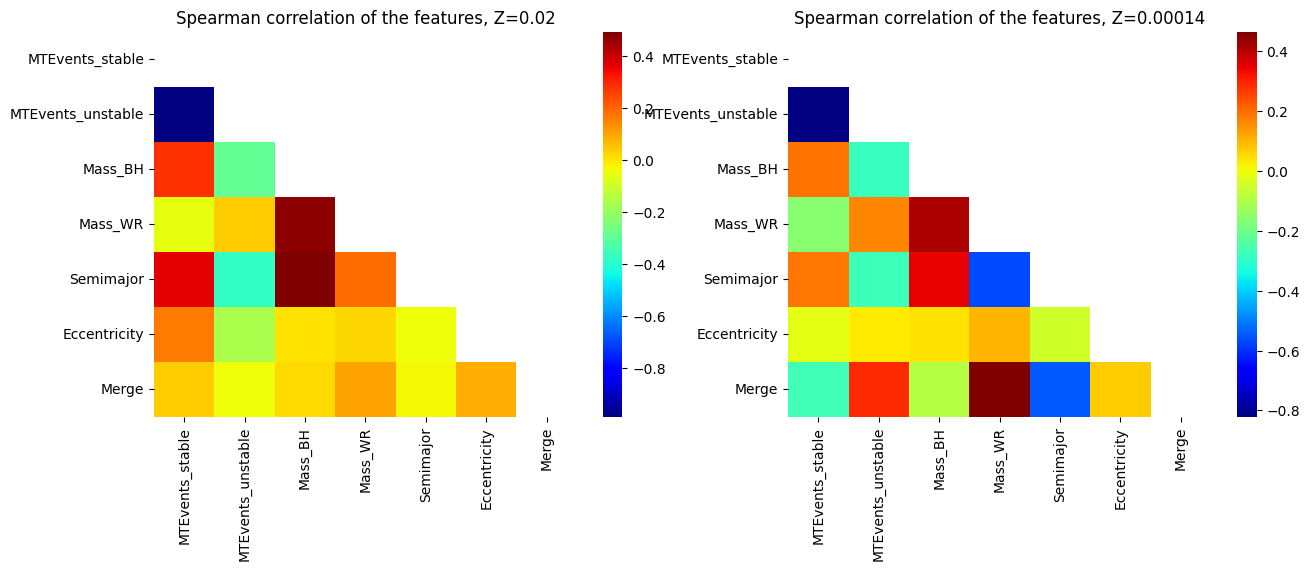

In [38]:
fig,axs=plt.subplots(1,2,figsize=(15,5))
corr_matrix_0 = df0.iloc[:,[1,2,4,5,6,7,8]].corr(method='spearman')
mask = np.triu(np.ones_like(corr_matrix_0, dtype=bool))
sns.heatmap((corr_matrix_0), mask=mask, cmap='jet', linecolor='w',ax=axs[0])
axs[0].set_title('Spearman correlation of the features, Z=0.02')

corr_matrix_1 = df1.iloc[:,[1,2,4,5,6,7,8]].corr(method='spearman')
mask = np.triu(np.ones_like(corr_matrix_1, dtype=bool))
sns.heatmap((corr_matrix_1), mask=mask, cmap='jet', linecolor='w',ax=axs[1])
axs[1].set_title('Spearman correlation of the features, Z=0.00014')
plt.show()

In [40]:
x0 = df0[['MTEvents_stable', 'MTEvents_unstable', 'Mass_BH', 'Mass_WR', 'Semimajor', 'Eccentricity', 'Mass_ratio']]
y0 = df0.Merge

N, L = x0.shape[0], x0.shape[1]
print("N: ",N,"L: ",L)

N_train = int(0.2*N)
x_train,y_train = x0[:N_train], y0[:N_train]
x_test,y_test = x0[N_train:], y0[N_train:]


N:  31595 L:  7


In [50]:
#parameter's grid
param_grid_rf = {'n_estimators': [30,60,80,150],
                 'max_depth': [3, 5, 7, 12]}

#random forest model
rand_for = RandomForestClassifier(criterion='gini') 


grid_search_rand_for = GridSearchCV(estimator=rand_for, param_grid=param_grid_rf, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_result_rand_for = grid_search_rand_for.fit(x_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [51]:
rand_for_res_gs=pd.DataFrame(grid_result_rand_for.cv_results_) #random forest results grid search

#adding column for computational time
rand_for_res_gs['mean_fit_time'] = grid_result_rand_for.cv_results_['mean_fit_time']

#printing results
rand_for_res_red=rand_for_res_gs[['rank_test_score','mean_fit_time','std_fit_time','params','mean_test_score','std_test_score']].sort_values(by='mean_test_score', ascending=False)
rand_for_res_red

,rank_test_score,mean_fit_time,std_fit_time,params,mean_test_score,std_test_score
0,1,0.278340,0.045152,"{'max_depth': 3, 'n_estimators': 30}",0.995094,0.000316
1,1,0.546919,0.040769,"{'max_depth': 3, 'n_estimators': 60}",0.995094,0.000316
2,1,0.747481,0.082841,"{'max_depth': 3, 'n_estimators': 80}",0.995094,0.000316
3,4,1.444831,0.075760,"{'max_depth': 3, 'n_estimators': 150}",0.994936,0.000633
4,4,0.393517,0.082036,"{'max_depth': 5, 'n_estimators': 30}",0.994936,0.000633
5,4,0.674610,0.063032,"{'max_depth': 5, 'n_estimators': 60}",0.994936,0.000633
6,4,0.889149,0.099197,"{'max_depth': 5, 'n_estimators': 80}",0.994936,0.000633
7,4,1.638089,0.107957,"{'max_depth': 5, 'n_estimators': 150}",0.994936,0.000633
8,4,0.346595,0.016220,"{'max_depth': 7, 'n_estimators': 30}",0.994936,0.000633
9,4,0.744130,0.128558,"{'max_depth': 7, 'n_estimators': 60}",0.994936,0.000633


In [57]:
best_rand_for = RandomForestClassifier(n_estimators=80, max_depth=7, criterion='gini', n_jobs=-1)

best_rand_for.fit(x_train,y_train)
y_hat = best_rand_for.predict(x_test)

print("errors: {:.2f}%   Accuracy={:.3f}".format(100*(1-best_rand_for.score(x_test, y_test)), best_rand_for.score(x_test, y_test)))

errors: 0.58%   Accuracy=0.994


([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'MTEvents_stable'),
  Text(1, 0, 'MTEvents_unstable'),
  Text(2, 0, 'Mass_BH'),
  Text(3, 0, 'Mass_WR'),
  Text(4, 0, 'Semimajor'),
  Text(5, 0, 'Eccentricity'),
  Text(6, 0, 'Mass_ratio')])

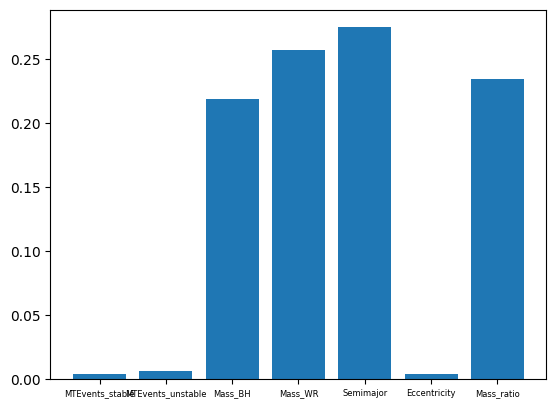

In [56]:
features = ['MTEvents_stable', 'MTEvents_unstable', 'Mass_BH', 'Mass_WR', 'Semimajor', 'Eccentricity', 'Mass_ratio']
plt.bar(features, best_rand_for.feature_importances_)
plt.xticks(fontsize=6)